# Project: This is why hosting on Airbnb doesn't have to be a fit for you.
- Description: Segmentation of Airbnb hosts by means of listings data from Boston and Seattle.
- Datasets:
  - Seattle: https://www.kaggle.com/datasets/airbnb/seattle
  - Boston: https://www.kaggle.com/datasets/airbnb/boston
- Responsible: Christian Graber
- Date: 25.12.2022


## Setup

### Libraries

In [1]:
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt
import sklearn
from sklearn.decomposition import PCA
from sklearn.cluster import KMeans
from sklearn.preprocessing import MinMaxScaler
import seaborn as sns
from pyclustertend import hopkins

import warnings
warnings.filterwarnings('ignore')


### Settings

In [2]:

pd.set_option('display.max_rows', 500)
pd.set_option('display.max_columns', 500)
pd.set_option('display.width', 150)

## Data Gathering

In [3]:
# Boston (https://www.kaggle.com/datasets/airbnb/boston)
## URIs 
uri_calenderBoston = '/home/q282675/training/dataScientist/project-1/data/boston/calendar.csv'
uri_listingsBoston = '/home/q282675/training/dataScientist/project-1/data/boston/listings.csv'
uri_reviewsBoston = '/home/q282675/training/dataScientist/project-1/data/boston/reviews.csv'

## Read
df_calenderBoston = pd.read_csv(uri_calenderBoston)
df_listingsBoston = pd.read_csv(uri_listingsBoston)
df_reviewsBoston = pd.read_csv(uri_reviewsBoston)

In [4]:
# Seattle (https://www.kaggle.com/datasets/airbnb/seattle)
## URIs
uri_calenderSeattle = '/home/q282675/training/dataScientist/project-1/data/seattle/calendar.csv'
uri_listingsSeattle = '/home/q282675/training/dataScientist/project-1/data/seattle/listings.csv'
uri_reviewsSeattle = '/home/q282675/training/dataScientist/project-1/data/seattle/reviews.csv'
uriMeta_calenderSeattle = '/home/q282675/training/dataScientist/project-1/data/seattle/meta_calender_seattle.csv'
uriMeta_listingsSeattle = '/home/q282675/training/dataScientist/project-1/data/seattle/meta_listings_seattle.csv'
uriMeta_reviewsSeattle = '/home/q282675/training/dataScientist/project-1/data/seattle/meta_reviews_seattle.csv'

## Read
df_calenderSeattle = pd.read_csv(uri_calenderSeattle)
df_listingsSeattle = pd.read_csv(uri_listingsSeattle)
df_reviewsSeattle = pd.read_csv(uri_reviewsSeattle)
listings_metadata = pd.read_csv(uriMeta_listingsSeattle)
calendar_metadata = pd.read_csv(uriMeta_calenderSeattle)
reviews_metadata = pd.read_csv(uriMeta_reviewsSeattle)

## Data Assessment

#### Compare column headers for Boston and Seattle.


In [5]:
## calender
diffCalender = df_calenderBoston.columns.difference(df_calenderSeattle.columns)
diffCalender

Index([], dtype='object')

In [6]:
## listings
diffListings = df_listingsBoston.columns.difference(df_listingsSeattle.columns)
diffListings

Index(['access', 'house_rules', 'interaction'], dtype='object')

In [7]:
## reviews
diffReviews = df_reviewsBoston.columns.difference(df_reviewsSeattle.columns)
diffReviews

Index([], dtype='object')

Summary:
- No differences of column headers for 'calender' and 'reviews' datasets of Boston and Seattle.
- Minor differences for 'listings' datasets of Boston and Seattle. -> Neglect columns ['access', 'house_rules', 'interaction'] in feature selection.
- Visual assesment of datasets is sufficient for one city.

#### Feature Selection
- Focus on subset listings.csv.
- Feature selection is based on human intuition / personal experience.

In [8]:
# Features of Interest
subsetListings=['host_id', 'host_about', 'host_response_time', 'host_response_rate', 'host_acceptance_rate', 'host_is_superhost', 'host_has_profile_pic', 'host_identity_verified', 'market', 'room_type', 'minimum_nights', 'maximum_nights', 'availability_365', 'number_of_reviews', 'review_scores_rating', 'instant_bookable', 'cancellation_policy', 'require_guest_profile_picture', 'require_guest_phone_verification']

# Select Features
df_listings = pd.concat([df_listingsSeattle[subsetListings], df_listingsBoston[subsetListings]])

# Number of Observations/Features
df_listings.shape

(7403, 19)

#### Overall View

In [9]:
df_listings.head()

,host_id,host_about,host_response_time,host_response_rate,host_acceptance_rate,host_is_superhost,host_has_profile_pic,host_identity_verified,market,room_type,minimum_nights,maximum_nights,availability_365,number_of_reviews,review_scores_rating,instant_bookable,cancellation_policy,require_guest_profile_picture,require_guest_phone_verification
0,956883,"I am an artist, interior designer, and run a s...",within a few hours,96%,100%,f,t,t,Seattle,Entire home/apt,1,365,346,207,95.0,f,moderate,f,f
1,5177328,Living east coast/left coast/overseas. Time i...,within an hour,98%,100%,t,t,t,Seattle,Entire home/apt,2,90,291,43,96.0,f,strict,t,t
2,16708587,i love living in Seattle. i grew up in the mi...,within a few hours,67%,100%,f,t,t,Seattle,Entire home/apt,4,30,220,20,97.0,f,strict,f,f
3,9851441,NaN,NaN,NaN,NaN,f,t,t,Seattle,Entire home/apt,1,1125,143,0,NaN,f,flexible,f,f
4,1452570,"Hi, I live in Seattle, Washington but I'm orig...",within an hour,100%,NaN,f,t,t,Seattle,Entire home/apt,1,1125,365,38,92.0,f,strict,f,f


In [10]:
df_listings.info()

<class 'pandas.core.frame.DataFrame'>
Int64Index: 7403 entries, 0 to 3584
Data columns (total 19 columns):
 #   Column                            Non-Null Count  Dtype  
---  ------                            --------------  -----  
 0   host_id                           7403 non-null   int64  
 1   host_about                        5235 non-null   object 
 2   host_response_time                6409 non-null   object 
 3   host_response_rate                6409 non-null   object 
 4   host_acceptance_rate              6159 non-null   object 
 5   host_is_superhost                 7401 non-null   object 
 6   host_has_profile_pic              7401 non-null   object 
 7   host_identity_verified            7401 non-null   object 
 8   market                            7389 non-null   object 
 9   room_type                         7403 non-null   object 
 10  minimum_nights                    7403 non-null   int64  
 11  maximum_nights                    7403 non-null   int64  
 12  availa

In [11]:
df_listings.describe()

,host_id,minimum_nights,maximum_nights,availability_365,number_of_reviews,review_scores_rating
count,7.403000e+03,7403.000000,7.403000e+03,7403.000000,7403.000000,5943.000000
mean,2.021053e+07,2.757666,1.431337e+04,213.089153,20.684047,93.316002
std,1.962309e+07,13.243828,1.162232e+06,138.342837,36.733024,8.207451
min,4.193000e+03,1.000000,1.000000e+00,0.000000,0.000000,20.000000
25%,4.343164e+06,1.000000,9.550000e+01,77.000000,1.000000,91.000000
50%,1.448650e+07,2.000000,1.125000e+03,259.000000,7.000000,96.000000
75%,3.028359e+07,3.000000,1.125000e+03,347.000000,23.000000,99.000000
max,9.385411e+07,1000.000000,1.000000e+08,365.000000,474.000000,100.000000


Note:
- Values of 'availability_365',	'number_of_reviews' and	'review_scores_rating' are within reasonable limits.
- Features 'mimimum_nights' and 'maximum_nights' have max values, which exceed Q3 (75%) by more than 3 x IQR. Therefore these features have probably some extreme values (outliers). Detailed assessment of these features by boxplots.

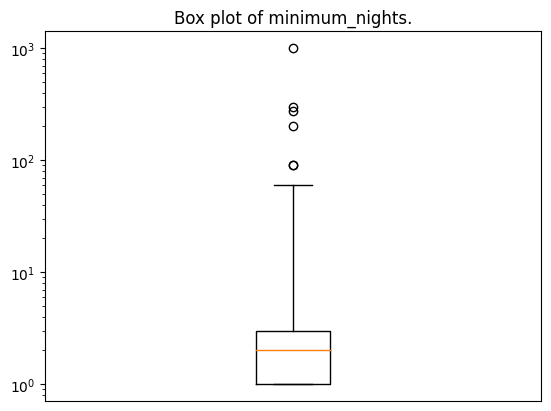

Values of Whiskers: [1.0, 60.0]


In [12]:
# Visualize numeric features of interest by means of a boxplots.
## Box plot of minimum_nights
fig1, ax1 = plt.subplots()
ax1.set_title('Box plot of minimum_nights.')
bp_minimumNights = ax1.boxplot(df_listings['minimum_nights'], whis=[0.1,99.9])
plt.yscale("log")
plt.tick_params(
    axis='x',          # changes apply to the x-axis
    which='both',      # both major and minor ticks are affected
    bottom=False,      # ticks along the bottom edge are off
    top=False,         # ticks along the top edge are off
    labelbottom=False) # labels along the bottom edge are off
plt.show();

## Whisker Values
wv_minimumNights = [item.get_ydata()[1] for item in bp_minimumNights['whiskers']]
print(f'Values of Whiskers: {wv_minimumNights}')

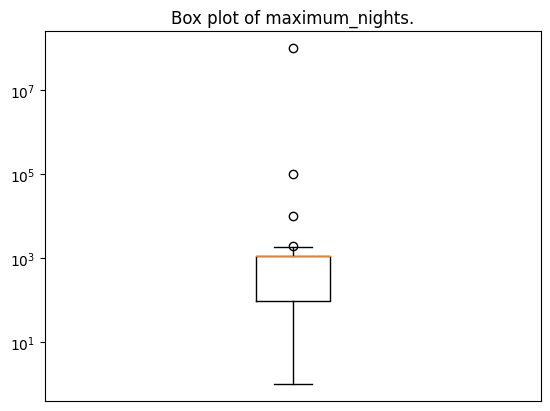

Values of Whiskers: [1.0, 1825.0]


In [13]:
## Box plot of maximum_nights
fig2, ax2 = plt.subplots()
ax2.set_title('Box plot of maximum_nights.')
bp_maximumNights = ax2.boxplot(df_listings['maximum_nights'], whis=[0.1,99.9])
plt.yscale("log")
plt.tick_params(
    axis='x',          # changes apply to the x-axis
    which='both',      # both major and minor ticks are affected
    bottom=False,      # ticks along the bottom edge are off
    top=False,         # ticks along the top edge are off
    labelbottom=False) # labels along the bottom edge are off
plt.show();

## Whisker Values
wv_maximumNights = [item.get_ydata()[1] for item in bp_maximumNights['whiskers']]
print(f'Values of Whiskers: {wv_maximumNights}')

Note: Outliers from features 'minimum_nights' and 'maximum_nights' have to be removed for proper clustering. By means of the following upper thresholds only 8 observations will be removed or 99.8% of data will remain in the considered dataset:
- threshold_minimum_nights = 60
- threshold_maximum_nights = 1825 

## Data Cleaning

- host_id: N/A                      
- host_since: drop 
- host_location: drop
- host_about: convert column (1: available / 0: not available); dtype: int64                      
- host_response_time: encode categorical data (One Hot Encoding); dtype: int64; drop nulls
- host_response_rate: convert str to float; dtype: float64; drop nulls           
- host_acceptance_rate: convert str to float; dtype: float64; drop nulls
- host_is_superhost: encode categorical data (1: t / 0: f); dtype: int64; drop nulls         
- host_verifications: drop
- host_has_profile_pic: encode categorical data (1: t / 0: f); dtype: int64; drop nulls
- host_identity_verified: encode categorical data (1: t / 0: f); dtype: int64; drop nulls
- market (not used for ML): drop nulls, remove observations with market different of 'Seattle' & 'Boston'.                      
- room_type: convert column (1: shared living == private room / 0: not shared living)
- property_type: drop                   
- minimum_nights: convert to ordinal, Remove outliers; encode categorical data (One Hot Encoding)                
- maximum_nights:Remove Outliers; Min-Max Normalization; dtype: float64  (not used for ML, only for filtering/analysis)
- availability_365: Min-Max Normalization; dtype: float64  (not used for ML, only for filtering/analysis)
- number_of_reviews (not used for ML, only for filtering/analysis): N/A
- review_scores_rating: drop nulls; Min-Max Normalization
- instant_bookable: encode categorical data (1: t / 0: f); dtype: int64
- cancellation_policy: encode categorical data (One Hot Encoding); dtype: int64
- require_guest_profile_picture: encode categorical data (1: t / 0: f); dtype: int64
- require_guest_phone_verification: encode categorical data (1: t / 0: f); dtype: int64
- calculated_host_listings_count: drop

### Messy & Tidyness Issues

In [86]:
# nulls
df_clean = df_listings.dropna(subset=['host_response_time','host_response_rate','host_acceptance_rate','host_is_superhost','host_has_profile_pic','host_identity_verified','market','review_scores_rating'])
df_clean.shape

(5224, 19)

In [87]:
# host_about: convert column (1: available / 0: not available); dtype: int64
df_clean['host_about'] = df_clean['host_about'].notnull().astype(int)

In [88]:
# host_response_time: encode categorical data (One Hot Encoding); dtype: int64
df_clean = pd.get_dummies(df_clean, columns=['host_response_time','cancellation_policy'], dtype='int64')

In [89]:
# host_response_rate: convert str to float; dtype: float64
df_clean['host_response_rate'] = df_clean['host_response_rate'].str.rstrip('%').astype(float)/100.0

In [90]:
# host_acceptance_rate: convert str to float; dtype: float64
df_clean['host_acceptance_rate'] = df_clean['host_acceptance_rate'].str.rstrip('%').astype(float)/100.0

In [91]:
# encode categorical data (1: t / 0: f); dtype: int64
dictMapping = {'t': True, 'f': False}
cols = ['host_is_superhost','host_has_profile_pic','host_identity_verified','instant_bookable','require_guest_profile_picture','require_guest_phone_verification']

for col in cols:
    df_clean[col] = df_clean[col].map(dictMapping).astype(int)

In [92]:
# room_type: rename column; convert column (1: shared living == private room / 0: not shared living)
df_clean = df_clean.rename(columns={'room_type':'shared_living'})
dictMapping_shared = {'Entire home/apt': 0, 'Private room': 1, 'Shared room': 1}
df_clean['shared_living'] = df_clean['shared_living'].map(dictMapping_shared).astype(int)


In [93]:
# Remove Outliers of minimum_nights and maximum_nights
threshold_minimum_nights = 60
threshold_maximum_nights = 1825

df_clean = df_clean.query('minimum_nights <= @threshold_minimum_nights and maximum_nights <= @threshold_maximum_nights')

In [94]:
# Convert minimum_nights 
mapping_minimum_nights = {range(0, 2): 'NoRestrictions', range(2, 3): 'MoreThanNight', range(3, 7): 'MoreThanWeekend', range(7, 28): 'MoreThanWeek', range(28, 61): 'MoreThanMonth'}
df_clean['minimum_nights'] = df_clean['minimum_nights'].apply(lambda x: next((v for k, v in mapping_minimum_nights.items() if x in k), 0))
df_clean = pd.get_dummies(df_clean, columns=['minimum_nights'], dtype='int64')

In [95]:
# Remove observations with markets different of 'Seattle' & 'Boston'
df_clean = df_clean.query('market == "Seattle" or market == "Boston"')

In [96]:
# Convert dtype 'float64'.
df_clean[['availability_365','maximum_nights','number_of_reviews']] = df_clean[['availability_365','maximum_nights','number_of_reviews']].astype(np.float64)

### Normalization of numeric features

In [97]:
# Min-Max Normalization
df_norm = df_clean.copy()
scalerMinMax = MinMaxScaler()
df_norm[['availability_365','maximum_nights','review_scores_rating']] = scalerMinMax.fit_transform(df_norm[['availability_365','maximum_nights','review_scores_rating']])

In [157]:
df_clean.info()

<class 'pandas.core.frame.DataFrame'>
Int64Index: 5216 entries, 0 to 3583
Data columns (total 30 columns):
 #   Column                                 Non-Null Count  Dtype  
---  ------                                 --------------  -----  
 0   host_id                                5216 non-null   int64  
 1   host_about                             5216 non-null   int64  
 2   host_response_rate                     5216 non-null   float64
 3   host_acceptance_rate                   5216 non-null   float64
 4   host_is_superhost                      5216 non-null   int64  
 5   host_has_profile_pic                   5216 non-null   int64  
 6   host_identity_verified                 5216 non-null   int64  
 7   market                                 5216 non-null   object 
 8   shared_living                          5216 non-null   int64  
 9   maximum_nights                         5216 non-null   float64
 10  availability_365                       5216 non-null   float64
 11  numb

## Explorative Data Analysis

### Question-1: Do exist characteristic groups of hosts within the available data? And if so, how many?

#### Dimensionality Reduction by PCA

In [98]:
# Select features of interest and transform pandas dataframe to numpy array.
nparray_PCA = df_norm.drop(columns=['host_id','market','number_of_reviews','maximum_nights','availability_365']).to_numpy()

In [99]:
# Instantiate and train transformer object
pca = PCA(whiten=True, random_state=42).fit(nparray_PCA)

## whiten = True: Useful since down-stream model is K-Means Clustering algorithm [https://scikit-learn.org/stable/modules/decomposition.html#]

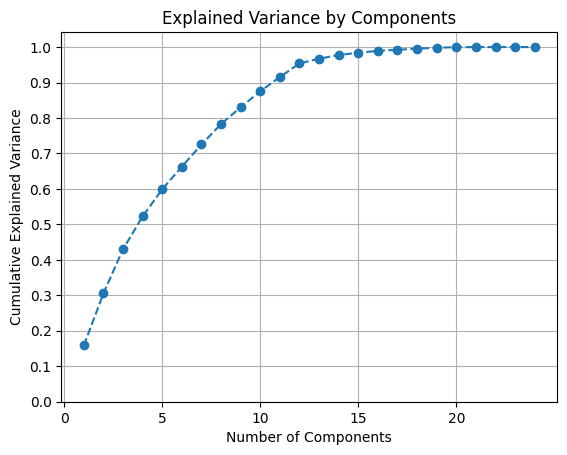

In [100]:
# Plot cumulative explained variance for selection of compoents.
plt.figure()
plt.plot(range(1, (pca.explained_variance_ratio_.size+1)), pca.explained_variance_ratio_.cumsum(), marker = 'o', linestyle = '--')
plt.title('Explained Variance by Components')
plt.xlabel('Number of Components')
plt.ylabel('Cumulative Explained Variance')
plt.xticks(range(0,(pca.explained_variance_ratio_.size+1),5))
plt.yticks(np.arange(0,1.1,0.1))
plt.grid();

Note: 
Usually (as a rule of thumb) the choosen number of components has to explain about 80% of variance. Since the plotted graph shows a distinct "elbow" (point: significant decrease of variance per component) I choose this point at a number of 12 components for further analysis (= explained variance ~ 96%).

In [101]:
# Fit the model and apply dimensionality reduction
nparray_ML = PCA(n_components=12, random_state=42).fit_transform(nparray_PCA)

#### Tendency Assessment via Hopkins's Statistic

In [102]:
# Calculate Hopkins Score
n=1000
hopkinsScore = hopkins(nparray_ML, n)
hopkinsScore

0.027125631738597854

Conclusion:
Positiv test result (an hopkins score which tends to 0), that means ...
- The data isn't randomly/uniformly distributed.
- Clustering can be meaningful for grouping the observations. 

#### Determination of Number of Clusters by Elbow Method


In [31]:
# Caclulate within-cluster (wcss) sum of squares
wcss = []
n_max_clusters = 30
for i in range(1, n_max_clusters):
    kmeans = KMeans(n_clusters = i).fit(nparray_ML)
    wcss.append(kmeans.inertia_)

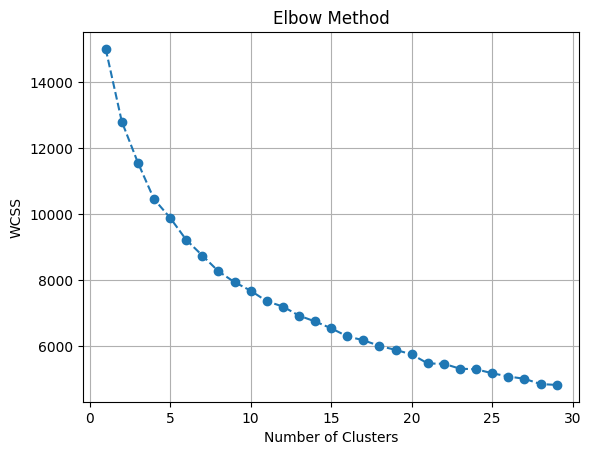

In [32]:
# Plot wcss by number of clusters
plt.plot(range(1, n_max_clusters), wcss, marker = 'o', linestyle = '--');
plt.title("Elbow Method")
plt.xlabel("Number of Clusters")
plt.ylabel("WCSS")
plt.grid()
plt.show()

Note:
- No distinct elbow.
- Number of clusters for further analysis: 9.

#### Clustering via k-means algorithm.

In [103]:
# Instantiate and fit k-means estimator according to processed data. 
kmeans = KMeans(n_clusters=9, random_state=42).fit(nparray_ML)

In [104]:
# Print labels and proportion of observations per label after clustering.
unique_elements, counts_elements = np.unique(kmeans.labels_, return_counts=True)
unique_elements, counts_elements/nparray_ML.shape[0]*100

(array([0, 1, 2, 3, 4, 5, 6, 7, 8], dtype=int32),
 array([10.58282209,  9.45168712,  9.49003067,  8.22469325,  9.87346626,
        10.41027607, 14.81978528, 15.10736196, 12.0398773 ]))

In [105]:
# Add clustering labels to dataframes df_norm and df_clean for further analysis.
df_norm['labelKmeans']=kmeans.labels_.tolist()
df_clean['labelKmeans']=kmeans.labels_.tolist()


### Further Questions: 
- 2: Do exist significant differences between these groups?
- 3: Do exist differences between Boston and Seattle?

##### Summary of features metrics per cluster.

In [106]:
df_clean.info()

<class 'pandas.core.frame.DataFrame'>
Int64Index: 5216 entries, 0 to 3583
Data columns (total 30 columns):
 #   Column                                 Non-Null Count  Dtype  
---  ------                                 --------------  -----  
 0   host_id                                5216 non-null   int64  
 1   host_about                             5216 non-null   int64  
 2   host_response_rate                     5216 non-null   float64
 3   host_acceptance_rate                   5216 non-null   float64
 4   host_is_superhost                      5216 non-null   int64  
 5   host_has_profile_pic                   5216 non-null   int64  
 6   host_identity_verified                 5216 non-null   int64  
 7   market                                 5216 non-null   object 
 8   shared_living                          5216 non-null   int64  
 9   maximum_nights                         5216 non-null   float64
 10  availability_365                       5216 non-null   float64
 11  numb

In [107]:
# Mean / Proportion for binary (0/1) features.
df_clean.drop(columns='host_id').select_dtypes(include='int64').groupby('labelKmeans').mean()

,host_about,host_is_superhost,host_has_profile_pic,host_identity_verified,shared_living,instant_bookable,require_guest_profile_picture,require_guest_phone_verification,host_response_time_a few days or more,host_response_time_within a day,host_response_time_within a few hours,host_response_time_within an hour,cancellation_policy_flexible,cancellation_policy_moderate,cancellation_policy_strict,cancellation_policy_super_strict_30,minimum_nights_MoreThanMonth,minimum_nights_MoreThanNight,minimum_nights_MoreThanWeek,minimum_nights_MoreThanWeekend,minimum_nights_NoRestrictions
labelKmeans,,,,,,,,,,,,,,,,,,,,,
0,0.760870,0.101449,1.000000,0.764493,0.221014,0.012681,0.088768,0.110507,0.003623,0.996377,0.000000,0.000000,0.173913,0.286232,0.538043,0.001812,0.016304,0.528986,0.025362,0.300725,0.128623
1,0.823529,0.302231,1.000000,0.890467,0.340771,0.344828,0.050710,0.070994,0.006085,0.000000,0.000000,0.993915,0.000000,0.993915,0.000000,0.006085,0.010142,0.744422,0.018256,0.227181,0.000000
2,0.832323,0.202020,0.997980,0.806061,0.466667,0.319192,0.042424,0.064646,0.010101,0.000000,0.000000,0.989899,0.000000,0.000000,1.000000,0.000000,0.000000,0.000000,0.000000,0.000000,1.000000
3,0.850816,0.242424,1.000000,0.853147,0.314685,0.030303,0.069930,0.240093,0.006993,0.000000,0.993007,0.000000,0.002331,0.951049,0.000000,0.046620,0.004662,0.594406,0.067599,0.328671,0.004662
4,0.654369,0.231068,0.996117,0.770874,0.561165,0.318447,0.021359,0.021359,0.000000,0.000000,0.000000,1.000000,1.000000,0.000000,0.000000,0.000000,0.003883,0.262136,0.013592,0.069903,0.650485
5,0.627993,0.121547,0.996317,0.646409,0.569061,0.051565,0.022099,0.023941,0.046041,0.281768,0.672192,0.000000,1.000000,0.000000,0.000000,0.000000,0.005525,0.197053,0.027624,0.095764,0.674033
6,0.861578,0.294955,0.997413,0.812419,0.208279,0.267788,0.129366,0.153946,0.001294,0.000000,0.000000,0.998706,0.000000,0.000000,1.000000,0.000000,0.011643,0.650712,0.032342,0.305304,0.000000
7,0.744924,0.170051,1.000000,0.851523,0.210660,0.104061,0.096447,0.159898,0.002538,0.000000,0.997462,0.000000,0.000000,0.000000,0.944162,0.055838,0.011421,0.294416,0.081218,0.388325,0.224619
8,0.757962,0.210191,0.998408,0.832803,0.525478,0.197452,0.028662,0.054140,0.011146,0.114650,0.285032,0.589172,0.000000,1.000000,0.000000,0.000000,0.001592,0.000000,0.000000,0.000000,0.998408


In [108]:
# Median for numeric (float) features.
floatFeaturesPlus = ['labelKmeans','host_response_rate','host_acceptance_rate','maximum_nights','availability_365','review_scores_rating']
df_clean[floatFeaturesPlus].groupby('labelKmeans').median()

,host_response_rate,host_acceptance_rate,maximum_nights,availability_365,review_scores_rating
labelKmeans,,,,,
0,0.96,1.00,1125.0,279.0,95.0
1,1.00,1.00,1125.0,275.0,96.0
2,1.00,1.00,1125.0,302.0,94.0
3,1.00,1.00,1125.0,222.0,95.0
4,1.00,1.00,1125.0,269.0,97.0
5,1.00,1.00,1125.0,276.0,96.0
6,1.00,1.00,1125.0,292.0,96.0
7,1.00,0.99,1125.0,296.0,94.0
8,1.00,1.00,1125.0,299.0,95.0


##### Detailed analysis of numeric (float) features. 

review_scores_rating

In [109]:
# Descriptive statistics of 'review_scores_rating'.
df_clean.groupby('labelKmeans')['review_scores_rating'].describe()

,count,mean,std,min,25%,50%,75%,max
labelKmeans,,,,,,,,
0,552.0,93.826087,6.296270,60.0,91.0,95.0,99.0,100.0
1,493.0,95.190669,4.452568,73.0,93.0,96.0,98.0,100.0
2,495.0,92.658586,7.860023,20.0,90.0,94.0,97.0,100.0
3,429.0,92.571096,9.008963,20.0,90.0,95.0,98.0,100.0
4,515.0,93.910680,8.061521,40.0,92.0,97.0,100.0,100.0
5,543.0,93.255985,8.946687,20.0,90.0,96.0,100.0,100.0
6,773.0,93.941785,7.426006,20.0,92.0,96.0,98.0,100.0
7,788.0,91.689086,9.570764,40.0,89.0,94.0,98.0,100.0
8,628.0,93.326433,7.149138,53.0,91.0,95.0,98.0,100.0


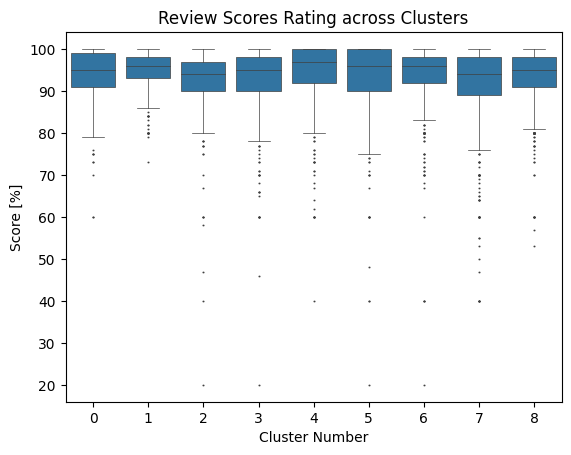

In [151]:
# Visualize 'review_scores_rating' by box plot per cluster.
fig = sns.boxplot(data=df_clean, x='labelKmeans', y='review_scores_rating', color='tab:blue', fliersize=0.5, linewidth=0.5)
fig.set_xlabel('Cluster Number')
fig.set_ylabel('Score [%]')
fig.set_title('Review Scores Rating across Clusters');

Conclusion: 
- Summary of simple statistics over all clusters.
  - Max. value is the same.
  - Minor differences of 1st, 2nd and 3rd quartile.
  - Min. value shows significant differences (see figure).
  - Mean and standard deviation will be neglected due to extreme values (minimums) of review_score_ratings.
- Only minor differences of 'review_score_ratings' exist in the available data. That means, the identified host segments are irrelevant for the customer experience. But maybe they can help increase host satisfaction by raising awareness of host diversity. 

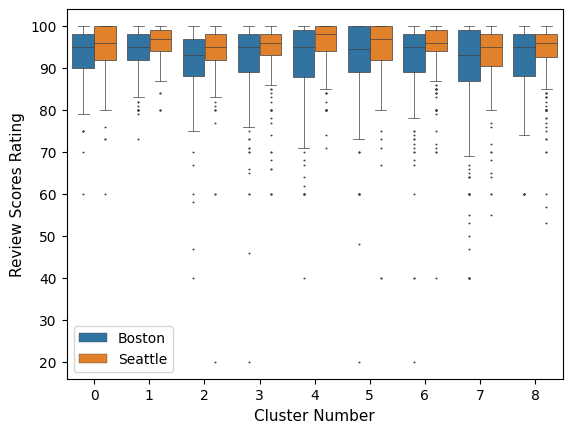

In [111]:
# Visualize 'review_scores_rating' by box plot per cluster for Seattle and Boston.
fig = sns.boxplot(data=df_clean, x='labelKmeans', y='review_scores_rating', hue='market', hue_order = ['Boston', 'Seattle'], fliersize=0.5, linewidth=0.5)
fig.set_xlabel('Cluster Number', fontsize = 11)
fig.set_ylabel('Review Scores Rating', fontsize = 11)
fig.legend_.set_title(None);

Conclusion: 
- Similar distribution for Boston and Seattle.
- Boston hosts have generally lower rates.

host_response_rate

In [112]:
# Descriptive statistics of 'host_response_rate'.
df_clean.groupby('labelKmeans')['host_response_rate'].describe()

,count,mean,std,min,25%,50%,75%,max
labelKmeans,,,,,,,,
0,552.0,0.887736,0.143249,0.38,0.800,0.96,1.0,1.0
1,493.0,0.988621,0.061132,0.25,1.000,1.00,1.0,1.0
2,495.0,0.984343,0.072329,0.19,1.000,1.00,1.0,1.0
3,429.0,0.961166,0.092393,0.00,0.960,1.00,1.0,1.0
4,515.0,0.989126,0.039498,0.67,1.000,1.00,1.0,1.0
5,543.0,0.892983,0.182357,0.00,0.855,1.00,1.0,1.0
6,773.0,0.985770,0.052997,0.00,1.000,1.00,1.0,1.0
7,788.0,0.943972,0.090106,0.30,0.900,1.00,1.0,1.0
8,628.0,0.961099,0.103450,0.25,0.990,1.00,1.0,1.0


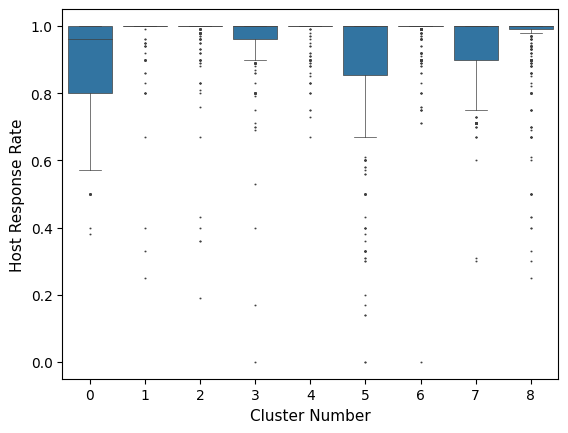

In [113]:
# Visualize 'host_response_rate' by box plot per cluster.
fig = sns.boxplot(data=df_clean, x='labelKmeans', y='host_response_rate', color='tab:blue', fliersize=0.5, linewidth=0.5)
fig.set_xlabel('Cluster Number', fontsize = 11)
fig.set_ylabel('Host Response Rate', fontsize = 11);

Conclusion: 
- Summary of simple statistics over all clusters.
  - 3rd quartile and max values are the same.
  - Minor differences of 2nd quartile.
  - Significant differences of 1st quartile and therefore of IQR.
  - Min. value shows significant differences.
  - Mean and standard deviation will be neglected due to extreme values (minimums).
- Clusters 0, 3, 5 and 7 show clearly bigger interquartile ranges (IQR). 

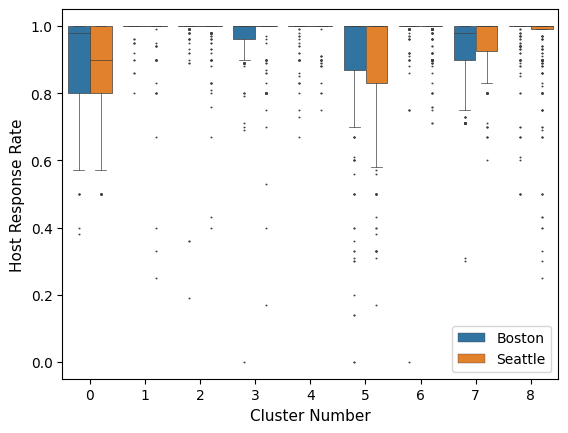

In [114]:
# Visualize 'host_response_rate' by box plot per cluster for Seattle and Boston.
fig = sns.boxplot(data=df_clean, x='labelKmeans', y='host_response_rate', hue='market', hue_order = ['Boston', 'Seattle'], fliersize=0.5, linewidth=0.5)
fig.set_xlabel('Cluster Number', fontsize = 11)
fig.set_ylabel('Host Response Rate', fontsize = 11)
fig.legend_.set_title(None);

Conclusion: 
- Similar behaviour for Seattle and Boston.
- Differences:
    - Different median within cluster 0 and 7
    - Different IQR within cluster 3, 5, 7 and 8.

host_acceptance_rate

In [115]:
# Descriptive statistics of 'host_acceptance_rate'.
df_clean.groupby('labelKmeans')['host_acceptance_rate'].describe()

,count,mean,std,min,25%,50%,75%,max
labelKmeans,,,,,,,,
0,552.0,0.871576,0.225544,0.0,0.8000,1.00,1.0,1.0
1,493.0,0.970649,0.118495,0.0,1.0000,1.00,1.0,1.0
2,495.0,0.955232,0.120129,0.0,0.9800,1.00,1.0,1.0
3,429.0,0.885152,0.181633,0.0,0.8000,1.00,1.0,1.0
4,515.0,0.975243,0.089760,0.0,1.0000,1.00,1.0,1.0
5,543.0,0.918453,0.171815,0.0,0.9100,1.00,1.0,1.0
6,773.0,0.957865,0.145724,0.0,1.0000,1.00,1.0,1.0
7,788.0,0.868058,0.199626,0.0,0.8075,0.99,1.0,1.0
8,628.0,0.954920,0.131389,0.0,1.0000,1.00,1.0,1.0


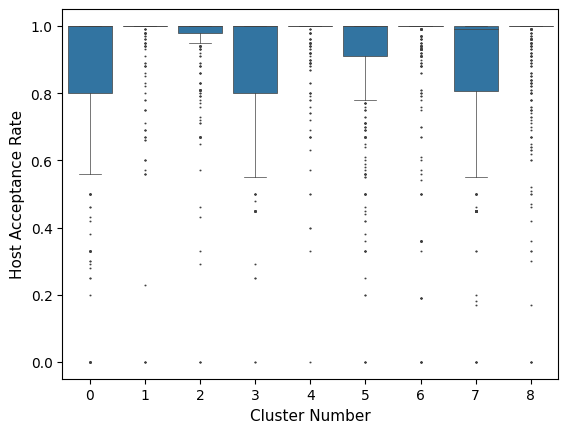

In [116]:
# Visualize 'host_acceptance_rate' by box plot per cluster.
fig = sns.boxplot(data=df_clean, x='labelKmeans', y='host_acceptance_rate', color='tab:blue', fliersize=0.5, linewidth=0.5)
fig.set_xlabel('Cluster Number', fontsize = 11)
fig.set_ylabel('Host Acceptance Rate', fontsize = 11);

Conclusion: 
- Summary of simple statistics over all clusters.
  - 3rd quartile and max values are the same.
  - Minor differences of 2nd quartile.
  - Significant differences of 1st quartile and therefore of IQR.
  - Min. value shows significant differences.
  - Mean and standard deviation will be neglected due to extreme values (minimums).
- Clusters 0, 2, 3, 5 and 7 show clearly bigger interquartile ranges (IQR). 

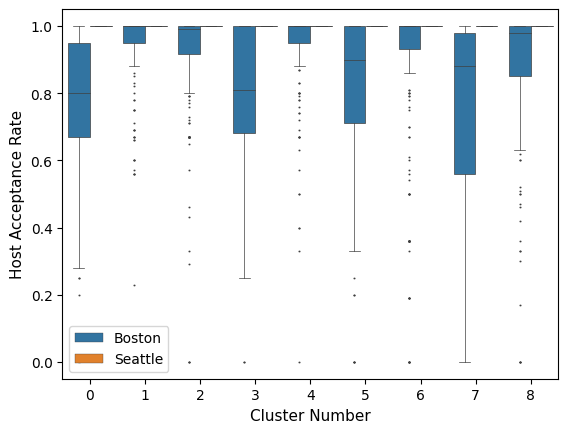

In [117]:
# Visualize 'host_acceptance_rate' by box plot per cluster for Seattle and Boston.
fig = sns.boxplot(data=df_clean, x='labelKmeans', y='host_acceptance_rate', hue='market', hue_order = ['Boston', 'Seattle'], fliersize=0.5, linewidth=0.5)
fig.set_xlabel('Cluster Number', fontsize = 11)
fig.set_ylabel('Host Acceptance Rate', fontsize = 11)
fig.legend_.set_title(None)
plt.legend(loc='lower left');

Conclusion: 
- Seattle: Unreasonable data (Acceptance rate of 100% seems not unlikely).
- Boston:
    - Similar behaviour (groups)) of clusters ...
        - 0, 3, 5 and 7.
        - 1, 2, 4, 6 and 8.
    - Max. values are the same.
    - Clearly visible differences:
        - 2nd and 3rd quartile.
        - IQR

##### Detailed analysis of binary (0/1) features. 

host_about

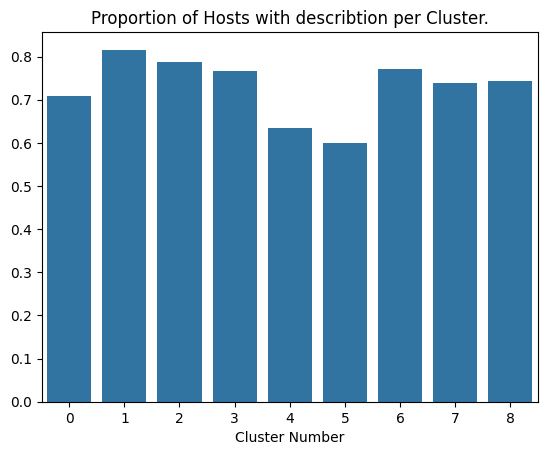

In [146]:
# Visualize 'host_about' by bar plot per cluster.
data = df_clean.drop_duplicates(subset=['host_id']).groupby('labelKmeans')['host_about'].mean().reset_index()
fig = sns.barplot(
    data=data,
    x='labelKmeans',
    y='host_about',
    color='tab:blue')
fig.set_xlabel('Cluster Number')
fig.set_ylabel(None)
fig.set_title('Proportion of Hosts with describtion per Cluster.');

Conclusion: 
- Clearly visible differences between clusters. 

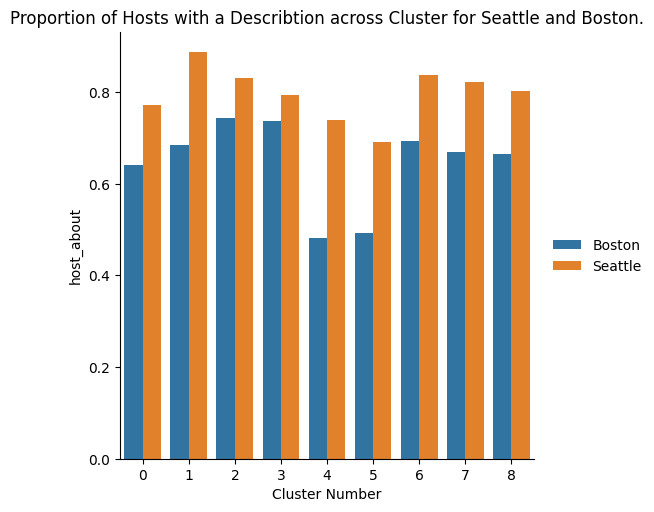

In [153]:
# Visualize 'host_about' by bar plot per cluster for Seattle and Boston.
data = df_clean.drop_duplicates(subset=['host_id']).groupby(['labelKmeans','market'])['host_about'].mean().reset_index()
fig = sns.catplot(
    data=data,
    kind='bar',
    x='labelKmeans',
    y='host_about',
    hue='market'
    , hue_order = ['Boston', 'Seattle']).set(title="Proportion of Hosts with a Describtion across Cluster for Seattle and Boston.")
fig.set_axis_labels('Cluster Number')
fig.legend.set_title('');

Conclusion: 
- Similar distribution for Boston and Seattle.
- Seattles host have generally more often a description. 

host_is_superhost

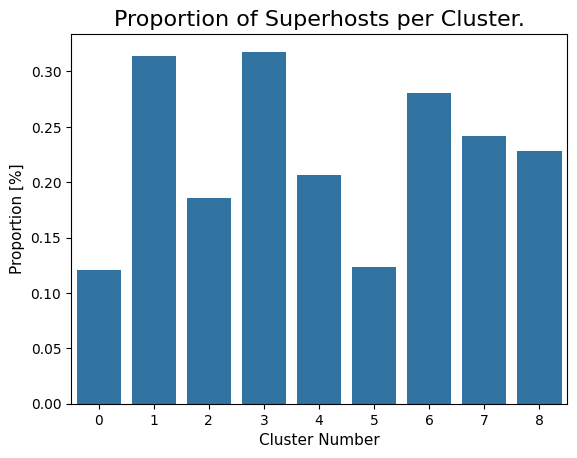

In [120]:
# Visualize 'host_is_superhost' by bar plot per cluster.
data = df_clean.drop_duplicates(subset=['host_id']).groupby('labelKmeans')['host_is_superhost'].mean().reset_index()
fig = sns.barplot(
    data=data,
    x='labelKmeans',
    y='host_is_superhost',
    color='tab:blue')
fig.set_xlabel('Cluster Number', fontsize = 11)
fig.set_ylabel('Proportion [%]', fontsize = 11)
fig.set_title('Proportion of Superhosts per Cluster.', fontsize = 16);

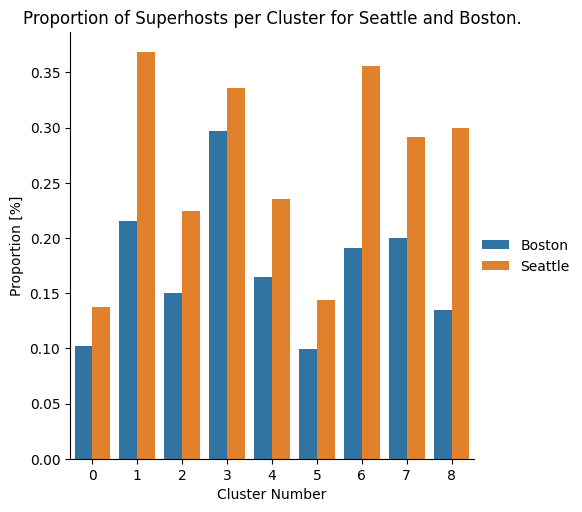

In [121]:
# Visualize 'host_is_superhost' by bar plot per cluster for Seattle and Boston.
data = df_clean.drop_duplicates(subset=['host_id']).groupby(['labelKmeans','market'])['host_is_superhost'].mean().reset_index()
fig = sns.catplot(
    data=data,
    kind='bar',
    x='labelKmeans',
    y='host_is_superhost',
    hue='market',
    hue_order = ['Boston', 'Seattle']    ).set(title="Proportion of Superhosts per Cluster for Seattle and Boston.")
fig.set_axis_labels('Cluster Number', 'Proportion [%]')
fig.legend.set_title('');

host_has_profile_pic

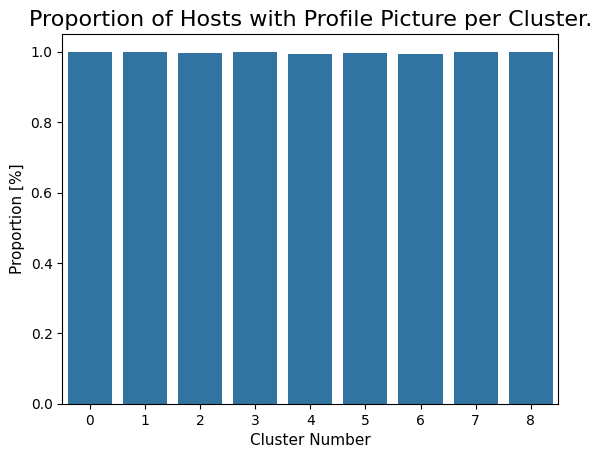

In [122]:
# Visualize 'host_has_profile_pic' by bar plot per cluster.
data = df_clean.drop_duplicates(subset=['host_id']).groupby('labelKmeans')['host_has_profile_pic'].mean().reset_index()
fig = sns.barplot(
    data=data,
    x='labelKmeans',
    y='host_has_profile_pic',
    color='tab:blue')
fig.set_xlabel('Cluster Number', fontsize = 11)
fig.set_ylabel('Proportion [%]', fontsize = 11)
fig.set_title('Proportion of Hosts with Profile Picture per Cluster.', fontsize = 16);

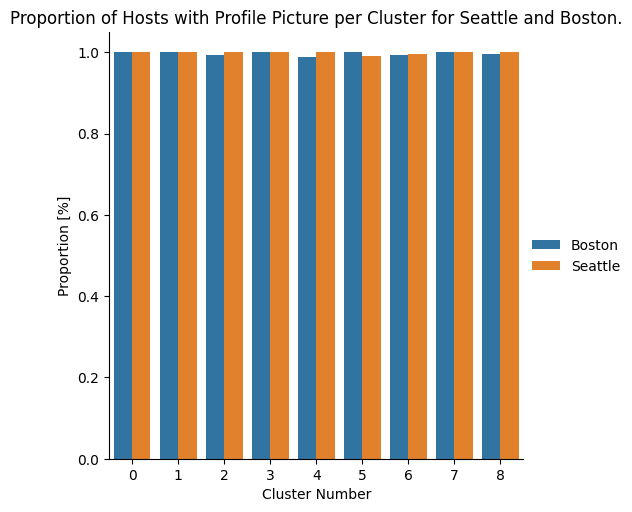

In [123]:
# Visualize 'host_has_profile_pic' by bar plot per cluster for Seattle and Boston.
data = df_clean.drop_duplicates(subset=['host_id']).groupby(['labelKmeans','market'])['host_has_profile_pic'].mean().reset_index()
fig = sns.catplot(
    data=data,
    kind='bar',
    x='labelKmeans',
    y='host_has_profile_pic',
    hue='market', 
    hue_order = ['Boston', 'Seattle']).set(title="Proportion of Hosts with Profile Picture per Cluster for Seattle and Boston.")
fig.set_axis_labels('Cluster Number', 'Proportion [%]')
fig.legend.set_title('');

host_identity_verified

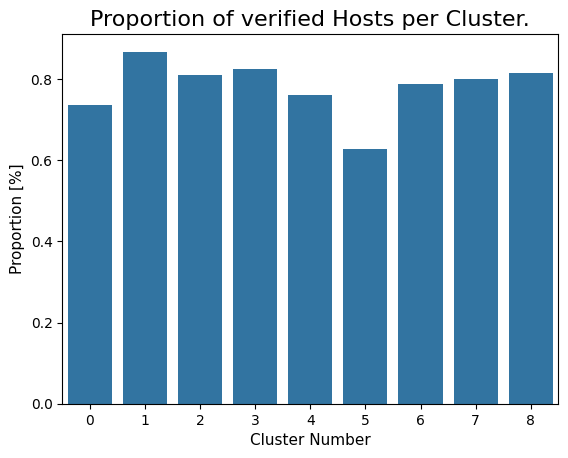

In [124]:
# Visualize 'host_identity_verified' by bar plot per cluster.
data = df_clean.drop_duplicates(subset=['host_id']).groupby('labelKmeans')['host_identity_verified'].mean().reset_index()
fig = sns.barplot(
    data=data,
    x='labelKmeans',
    y='host_identity_verified',
    color='tab:blue')
fig.set_xlabel('Cluster Number', fontsize = 11)
fig.set_ylabel('Proportion [%]', fontsize = 11)
fig.set_title('Proportion of verified Hosts per Cluster.', fontsize = 16);

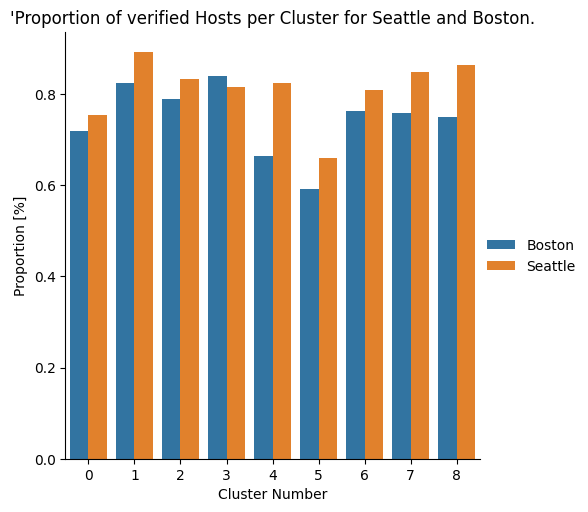

In [125]:
# Visualize 'host_identity_verified' by bar plot per cluster for Seattle and Boston.
data = df_clean.drop_duplicates(subset=['host_id']).groupby(['labelKmeans','market'])['host_identity_verified'].mean().reset_index()
fig = sns.catplot(
    data=data,
    kind='bar',
    x='labelKmeans',
    y='host_identity_verified',
    hue='market', 
    hue_order = ['Boston', 'Seattle']).set(title="'Proportion of verified Hosts per Cluster for Seattle and Boston.")
fig.set_axis_labels('Cluster Number', 'Proportion [%]')
fig.legend.set_title('');

shared_living

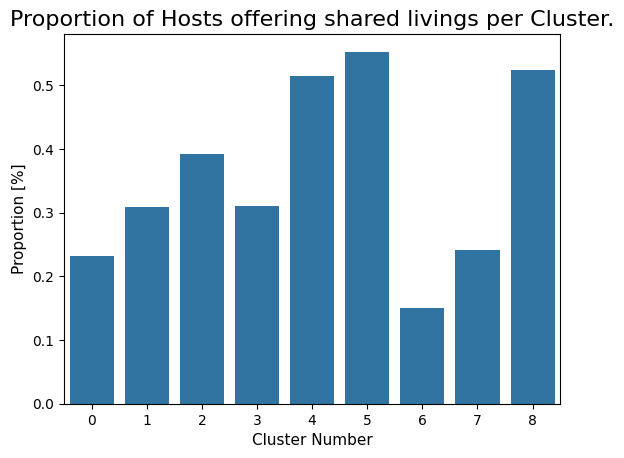

In [126]:
# Visualize 'shared_living' by bar plot per cluster.
data = df_clean.drop_duplicates(subset=['host_id']).groupby('labelKmeans')['shared_living'].mean().reset_index()
fig = sns.barplot(
    data=data,
    x='labelKmeans',
    y='shared_living',
    color='tab:blue')
fig.set_xlabel('Cluster Number', fontsize = 11)
fig.set_ylabel('Proportion [%]', fontsize = 11)
fig.set_title('Proportion of Hosts offering shared livings per Cluster.', fontsize = 16);

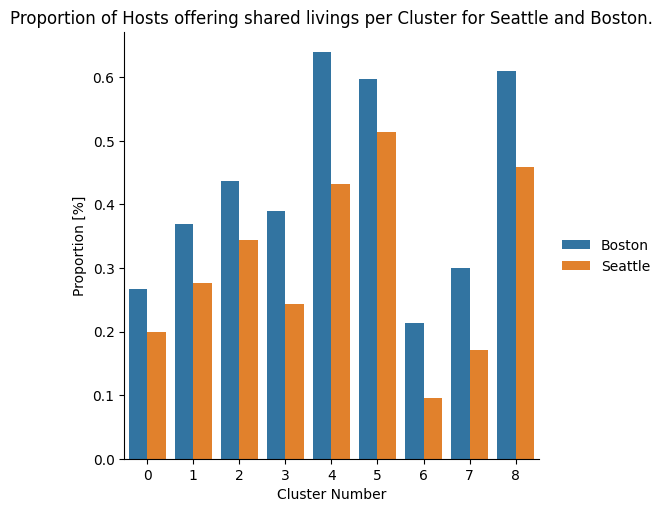

In [127]:
# Visualize 'shared_living' by bar plot per cluster for Seattle and Boston.
data = df_clean.drop_duplicates(subset=['host_id']).groupby(['labelKmeans','market'])['shared_living'].mean().reset_index()
fig = sns.catplot(
    data=data,
    kind='bar',
    x='labelKmeans',
    y='shared_living',
    hue='market', 
    hue_order = ['Boston', 'Seattle']).set(title="Proportion of Hosts offering shared livings per Cluster for Seattle and Boston.")
fig.set_axis_labels('Cluster Number', 'Proportion [%]')
fig.legend.set_title('');

instant_bookable

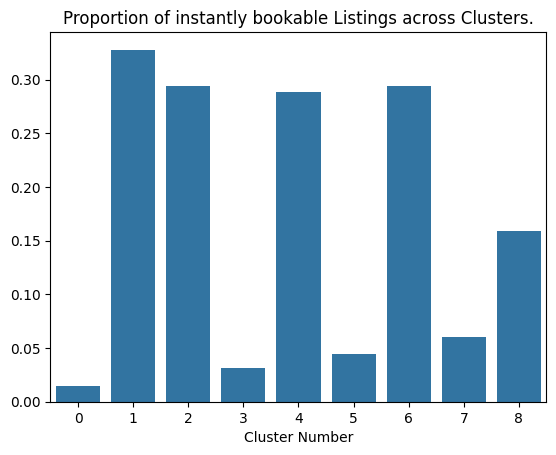

In [149]:
# Visualize 'instant_bookable' by bar plot per cluster.
data = df_clean.drop_duplicates(subset=['host_id']).groupby('labelKmeans')['instant_bookable'].mean().reset_index()
fig = sns.barplot(
    data=data,
    x='labelKmeans',
    y='instant_bookable',
    color='tab:blue')
fig.set_xlabel('Cluster Number')
fig.set_ylabel(None)
fig.set_title('Proportion of instantly bookable Listings across Clusters.');

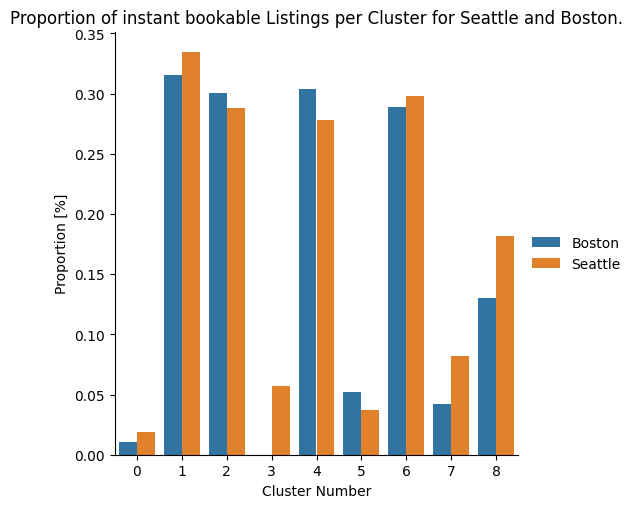

In [129]:
# Visualize 'instant_bookable' by bar plot per cluster for Seattle and Boston.
data = df_clean.drop_duplicates(subset=['host_id']).groupby(['labelKmeans','market'])['instant_bookable'].mean().reset_index()
fig = sns.catplot(
    data=data,
    kind='bar',
    x='labelKmeans',
    y='instant_bookable',
    hue='market', 
    hue_order = ['Boston', 'Seattle']).set(title="Proportion of instant bookable Listings per Cluster for Seattle and Boston.")
fig.set_axis_labels('Cluster Number', 'Proportion [%]')
fig.legend.set_title('');

require_guest_profile_picture

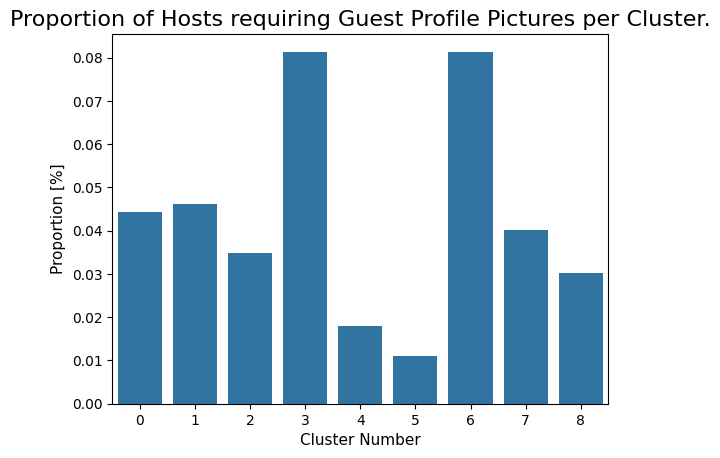

In [130]:
# Visualize 'require_guest_profile_picture' by bar plot per cluster.
data = df_clean.drop_duplicates(subset=['host_id']).groupby('labelKmeans')['require_guest_profile_picture'].mean().reset_index()
fig = sns.barplot(
    data=data,
    x='labelKmeans',
    y='require_guest_profile_picture',
    color='tab:blue')
fig.set_xlabel('Cluster Number', fontsize = 11)
fig.set_ylabel('Proportion [%]', fontsize = 11)
fig.set_title('Proportion of Hosts requiring Guest Profile Pictures per Cluster.', fontsize = 16);

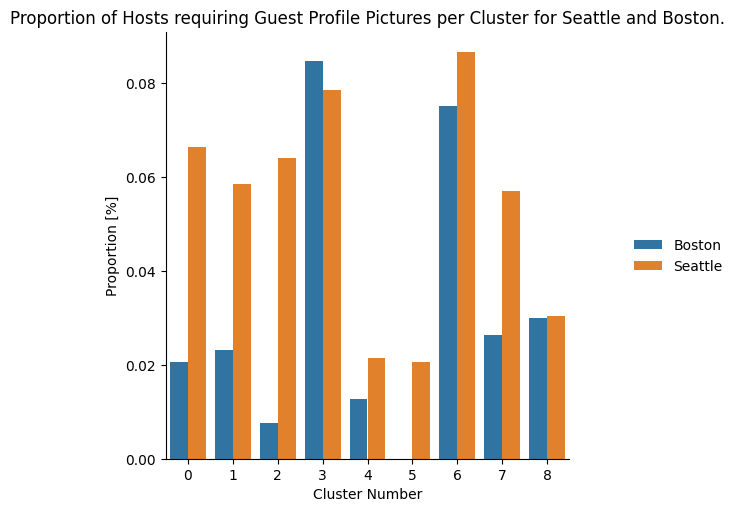

In [131]:
# Visualize 'require_guest_profile_picture' by bar plot per cluster  for Seattle and Boston.
data = df_clean.drop_duplicates(subset=['host_id']).groupby(['labelKmeans','market'])['require_guest_profile_picture'].mean().reset_index()
fig = sns.catplot(
    data=data,
    kind='bar',
    x='labelKmeans',
    y='require_guest_profile_picture',
    hue='market', 
    hue_order = ['Boston', 'Seattle']).set(title="Proportion of Hosts requiring Guest Profile Pictures per Cluster for Seattle and Boston.")
fig.set_axis_labels('Cluster Number', 'Proportion [%]')
fig.legend.set_title('');

require_guest_phone_verification

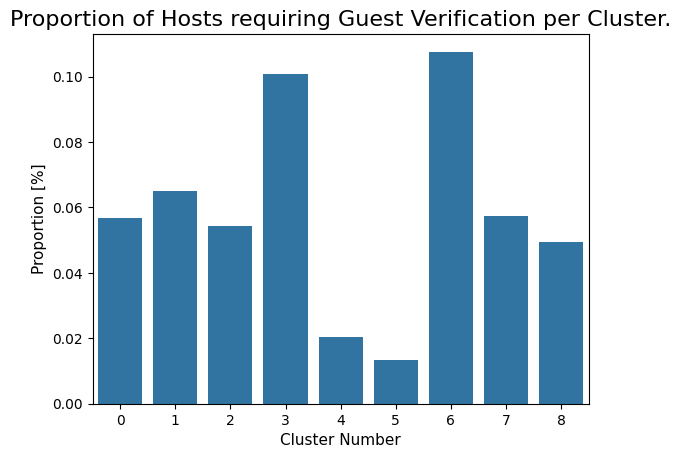

In [132]:
# Visualize 'require_guest_phone_verification' by bar plot per cluster.
data = df_clean.drop_duplicates(subset=['host_id']).groupby('labelKmeans')['require_guest_phone_verification'].mean().reset_index()
fig = sns.barplot(
    data=data,
    x='labelKmeans',
    y='require_guest_phone_verification',
    color='tab:blue')
fig.set_xlabel('Cluster Number', fontsize = 11)
fig.set_ylabel('Proportion [%]', fontsize = 11)
fig.set_title('Proportion of Hosts requiring Guest Verification per Cluster.', fontsize = 16);

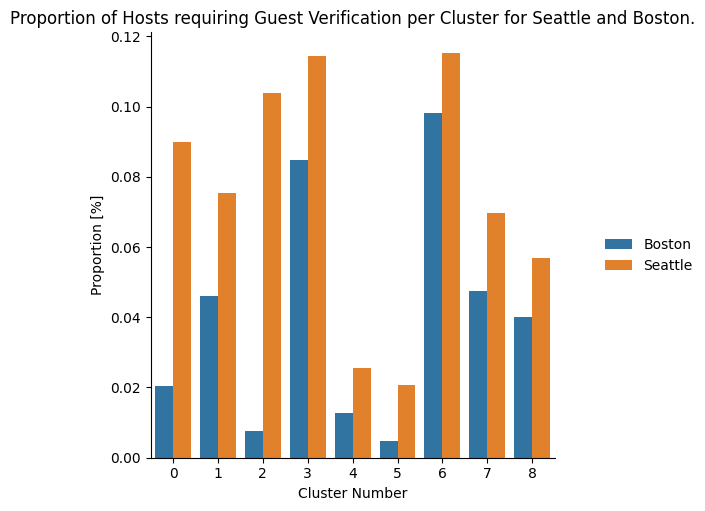

In [133]:
# Visualize 'require_guest_phone_verification' by bar plot per cluster  for Seattle and Boston.
data = df_clean.drop_duplicates(subset=['host_id']).groupby(['labelKmeans','market'])['require_guest_phone_verification'].mean().reset_index()
fig = sns.catplot(
    data=data,
    kind='bar',
    x='labelKmeans',
    y='require_guest_phone_verification',
    hue='market', 
    hue_order = ['Boston', 'Seattle']).set(title="Proportion of Hosts requiring Guest Verification per Cluster for Seattle and Boston.")
fig.set_axis_labels('Cluster Number', 'Proportion [%]')
fig.legend.set_title('');

host_response_time

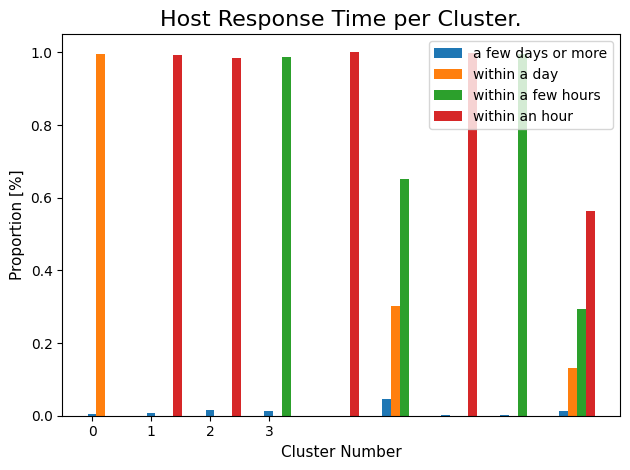

In [134]:
# Visualize 'host_response_time' by grouped bar plot per cluster.
features = ['host_response_time_a few days or more', 'host_response_time_within a day', 'host_response_time_within a few hours', 'host_response_time_within an hour']
categories = ['a few days or more','within a day','within a few hours','within an hour']
data = df_clean.drop_duplicates(subset=['host_id']).groupby('labelKmeans')[features].mean().reset_index()

width = 0.15

fig, ax = plt.subplots()

for cat in categories:
    ax.bar(data.labelKmeans+width*categories.index(cat), data[f'host_response_time_{cat}'], width, label=cat)

ax.set_xlabel('Cluster Number', fontsize = 11)
ax.set_ylabel('Proportion [%]', fontsize = 11)
ax.set_xticks(np.arange(0,4))
ax.set_title('Host Response Time per Cluster.', fontsize = 16)
ax.legend()

fig.tight_layout()

plt.show();

In [135]:
df_clean.head()

,host_id,host_about,host_response_rate,host_acceptance_rate,host_is_superhost,host_has_profile_pic,host_identity_verified,market,shared_living,maximum_nights,availability_365,number_of_reviews,review_scores_rating,instant_bookable,require_guest_profile_picture,require_guest_phone_verification,host_response_time_a few days or more,host_response_time_within a day,host_response_time_within a few hours,host_response_time_within an hour,cancellation_policy_flexible,cancellation_policy_moderate,cancellation_policy_strict,cancellation_policy_super_strict_30,minimum_nights_MoreThanMonth,minimum_nights_MoreThanNight,minimum_nights_MoreThanWeek,minimum_nights_MoreThanWeekend,minimum_nights_NoRestrictions,labelKmeans
0,956883,1,0.96,1.0,0,1,1,Seattle,0,365.0,346.0,207.0,95.0,0,0,0,0,0,1,0,0,1,0,0,0,0,0,0,1,8
1,5177328,1,0.98,1.0,1,1,1,Seattle,0,90.0,291.0,43.0,96.0,0,1,1,0,0,0,1,0,0,1,0,0,1,0,0,0,6
2,16708587,1,0.67,1.0,0,1,1,Seattle,0,30.0,220.0,20.0,97.0,0,0,0,0,0,1,0,0,0,1,0,0,0,0,1,0,7
6,2497928,1,1.00,1.0,1,1,1,Seattle,1,14.0,346.0,58.0,99.0,0,0,0,0,0,0,1,0,1,0,0,0,0,0,1,0,1
7,4016632,1,1.00,1.0,1,1,1,Seattle,1,7.0,100.0,173.0,97.0,0,1,1,0,0,0,1,0,0,1,0,0,1,0,0,0,6


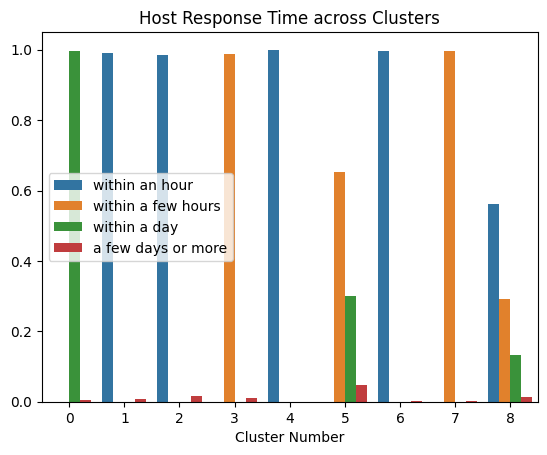

In [148]:
# Visualize 'host_response_time' by grouped bar plot per cluster.
## Data Preparation
data = df_clean.drop_duplicates(subset=['host_id'])[['labelKmeans','host_response_time_a few days or more', 'host_response_time_within a day', 'host_response_time_within a few hours', 'host_response_time_within an hour']]
data = pd.melt(data, id_vars = 'labelKmeans', value_vars = ['host_response_time_a few days or more', 'host_response_time_within a day', 'host_response_time_within a few hours', 'host_response_time_within an hour'], var_name='host_response_time').groupby(['labelKmeans','host_response_time']).mean().reset_index()
data['host_response_time']=data['host_response_time'].str[19:]

# Visualization
hue_order=['within an hour','within a few hours','within a day','a few days or more']
sns.barplot(x='labelKmeans', y='value', hue='host_response_time', hue_order=hue_order, data=data)
plt.ylabel(None)
plt.xlabel('Cluster Number')
plt.title('Host Response Time across Clusters')
plt.legend(title=None, loc='center left');

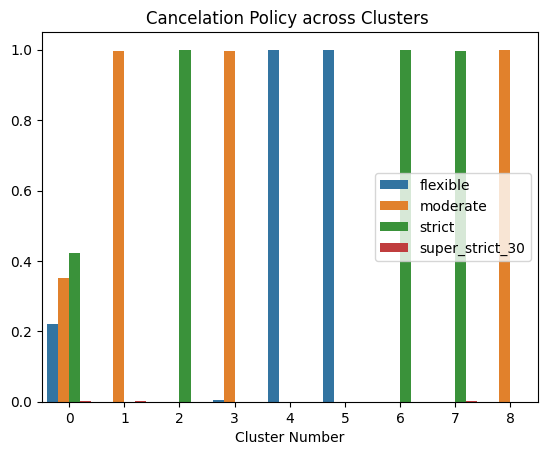

In [147]:
# Visualize 'cancellation_policy' by grouped bar plot per cluster.
## Data Preparation
data = df_clean.drop_duplicates(subset=['host_id'])[['labelKmeans','cancellation_policy_flexible', 'cancellation_policy_moderate', 'cancellation_policy_strict', 'cancellation_policy_super_strict_30']]
data = pd.melt(data, id_vars = 'labelKmeans', value_vars = ['cancellation_policy_flexible', 'cancellation_policy_moderate', 'cancellation_policy_strict', 'cancellation_policy_super_strict_30'], var_name='cancellation_policy').groupby(['labelKmeans','cancellation_policy']).mean().reset_index()
data['cancellation_policy']=data['cancellation_policy'].str[20:]

# Visualization
sns.barplot(x='labelKmeans', y='value', hue='cancellation_policy', data=data)
plt.ylabel(None)
plt.xlabel('Cluster Number')
plt.title('Cancelation Policy across Clusters ')
plt.legend(title=None, loc='center right');

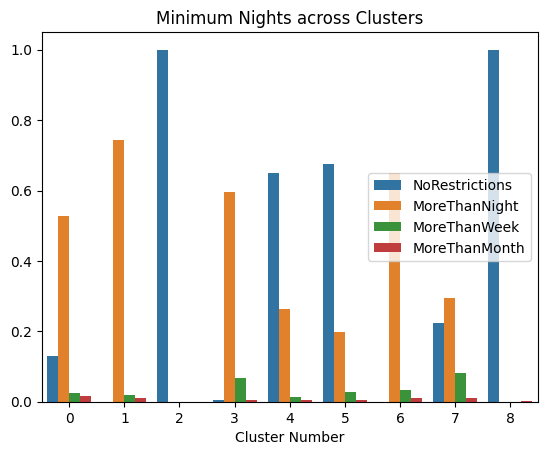

In [139]:
# Visualize 'minimum_nights' by grouped bar plot per cluster.
## Data Preparation
data = df_clean[['labelKmeans','minimum_nights_NoRestrictions', 'minimum_nights_MoreThanNight', 'minimum_nights_MoreThanWeek', 'minimum_nights_MoreThanMonth']]
data = pd.melt(data, id_vars = 'labelKmeans', value_vars = ['minimum_nights_NoRestrictions', 'minimum_nights_MoreThanNight', 'minimum_nights_MoreThanWeek', 'minimum_nights_MoreThanMonth'], var_name='minimum_nights').groupby(['labelKmeans','minimum_nights']).mean().reset_index()
data['minimum_nights']=data['minimum_nights'].str[15:]

# Visualization
hue_order=['NoRestrictions','MoreThanNight','MoreThanWeek','MoreThanMonth']
sns.barplot(x='labelKmeans', y='value', hue='minimum_nights', hue_order=hue_order, data=data)
plt.ylabel(None)
plt.xlabel('Cluster Number')
plt.title('Minimum Nights across Clusters')
plt.legend(title=None, loc='center right');